# In this notebook, the ARIMA and SARIMA models are explored

The methodology followed for producing an ARIMA model is summarized in the following flowchart, taken from Hyndmann.

![Hyndmann Modeling Porcess](hyndman-modeling-process.png)

In [3]:
%matplotlib inline

import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX

import tensorflow as tf
keras = tf.keras
from sklearn.model_selection import train_test_split

# Always make it pretty.
plt.style.use('ggplot')

# We get some interger -> float typecast warning from sklean below, this keeps them out of our hair.
import warnings
warnings.filterwarnings('ignore')

import pickle
from datetime import datetime

In [4]:
# get the data
df_CHN_CTC_leaf = pd.read_csv('../Data/df_CHN_CTC_leaf.csv')
# print(df_CHN_CTC_leaf.tail(40))
# grab 2020 data separately
df_CHN_CTC_leaf_2020 = df_CHN_CTC_leaf[pd.to_datetime(df_CHN_CTC_leaf['week_ending']) > pd.to_datetime('2020-01-01')]
df_CHN_CTC_leaf = df_CHN_CTC_leaf[pd.to_datetime(df_CHN_CTC_leaf['week_ending']) < pd.to_datetime('2020-01-01')]

price_series = df_CHN_CTC_leaf['ctc_leaf_avg_price']
time_series = pd.to_datetime(df_CHN_CTC_leaf['week_ending'])
price_series.index = time_series

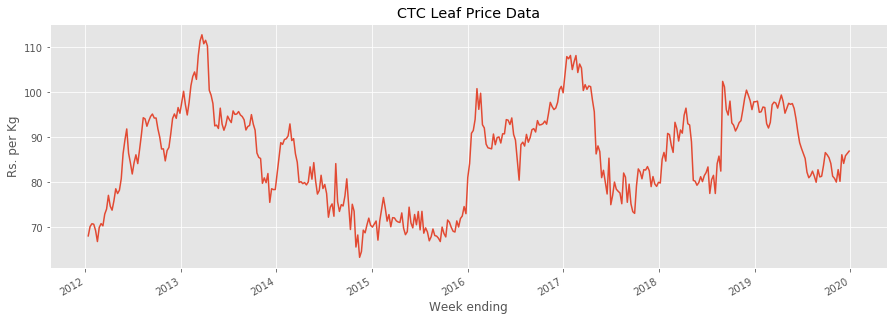

In [5]:
price_series.plot(figsize=(15,5))
plt.title('CTC Leaf Price Data')
plt.xlabel('Week ending');
plt.ylabel('Rs. per Kg');
plt.savefig('../Images/CTC_Leaf_Prices')

In [6]:
def plot_series_and_difference(axs, price_series, time_series, title):
    diff = price_series.diff()
    axs[0].plot(time_series, price_series)
    axs[0].set_title("Raw Series: {}".format(title))
    axs[1].plot(time_series, diff)
    axs[1].set_title("Series of First Differences: {}".format(title))

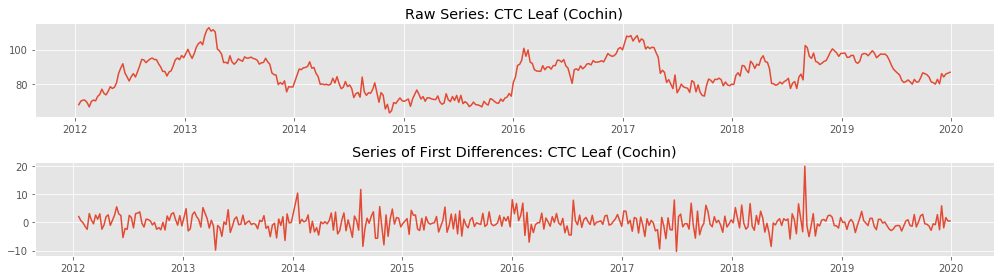

In [7]:
fig, axs = plt.subplots(2, figsize=(14, 4))
plot_series_and_difference(axs, price_series, time_series, 'CTC Leaf (Cochin)')
fig.tight_layout()
plt.savefig('../Images/Series_and_First_Differences')

In [8]:
# Check for stationarity
price_differences = price_series.diff()[1:]
ADF_p_value = sm.tsa.stattools.adfuller(price_differences)
print("ADF p-value for differenced price series: {0:2.2f}".format(ADF_p_value[1]))

ADF p-value for differenced price series: 0.00


So the differenced series is stationary, and we can attempt to model it as an ARMA process.

We need to determine the correct order for the AR and MA models, so let's look at the auto and partial auto correlation plots.

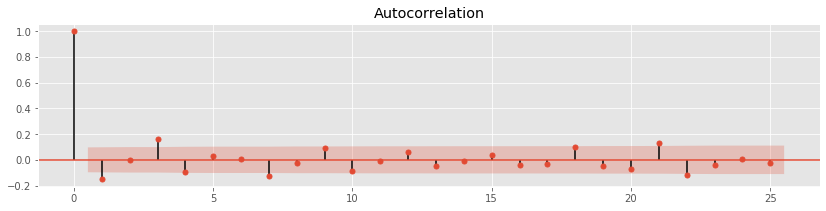

In [9]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_acf(price_differences, lags=25, ax=ax)
plt.savefig('../Images/Autocorrelation')

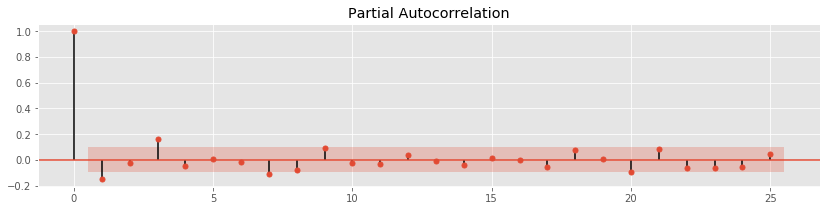

In [10]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_pacf(price_differences, lags=25, ax=ax)
plt.savefig('../Images/Partial_Autocorrelation')

We see the following evidence:
  - Oscillatory behavior in the autocorrelation plot. One significant data point at the beginning of the plot. So ?????
  - One significant partial autocorrelations at the beginning of the plot.
  
This suggests that the differenced series may be well modeled as an $AR(1)$ series.

Since we applied *one* difference to achieve stationarity, this suggests that we should model the *original* series as an $ARIMA(1, 1, 1)$.

In [11]:
# # try 2nd rder differencing
# # Check for stationarity
# price_second_differences = price_differences.diff()[1:]
# ADF_p_value = sm.tsa.stattools.adfuller(price_second_differences)
# print("ADF p-value for differenced price series: {0:2.2f}".format(ADF_p_value[1]))

In [12]:
# fig, ax = plt.subplots(1, figsize=(14, 3))
# _ = sm.graphics.tsa.plot_acf(price_second_differences, lags=25, ax=ax)
# fig, ax = plt.subplots(1, figsize=(14, 3))
# _ = sm.graphics.tsa.plot_pacf(price_second_differences, lags=25, ax=ax)

## Fit the ARIMA model

In [13]:
price_model = ARIMA(price_series, order=(1, 1, 0)).fit()

In [14]:
def format_list_of_floats(L):
    return ["{0:2.2f}".format(f) for f in L]

In [15]:
print("ARIMA(1, 1, 0) coefficients from Price model:\n  Intercept {0:2.2f}\n  AR {1}".format(
    price_model.params[0], 
        format_list_of_floats(list(price_model.params[1:]))
    ))

ARIMA(1, 1, 0) coefficients from Price model:
  Intercept 0.05
  AR ['-0.15']


Let's simulate some data using these coefficients and see if it looks like our differenced data.

In [16]:
def auto_regressive_process(size, coefs, init=None):
    """Generate an autoregressive process with Gaussian white noise.  The
    implementation is taken from here:
    
      http://numpy-discussion.10968.n7.nabble.com/simulate-AR-td8236.html
      
    Exaclty how lfilter works here takes some pen and paper effort.
    """
    coefs = np.asarray(coefs)
    if init == None:
        init = np.array([0]*len(coefs))
    else:
        init = np.asarray(init)
    init = np.append(init, np.random.normal(size=(size - len(init))))
    assert(len(init) == size)
    a = np.append(np.array([1]), -coefs)
    b = np.array([1])
    return pd.Series(signal.lfilter(b, a, init))

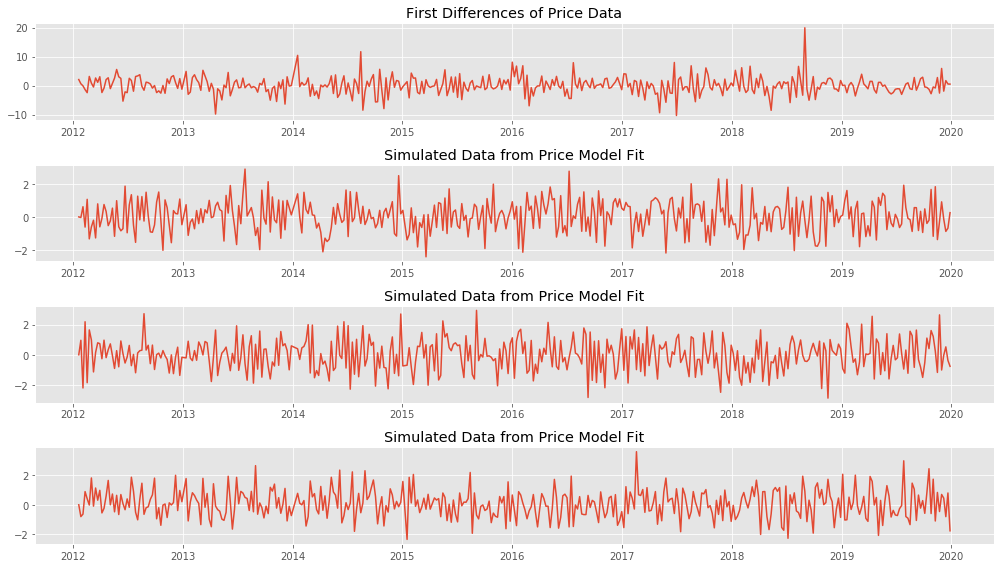

In [17]:
fig, ax = plt.subplots(4, figsize=(14, 8))

ax[0].plot(time_series[1:], price_differences)
ax[0].set_title("First Differences of Price Data")

for i in range(1, 4):
    simulated_data = auto_regressive_process(len(price_differences), 
                                             list(price_model.params)[1:])
    simulated_data.index = time_series[1:]
    ax[i].plot(simulated_data.index, simulated_data)
    ax[i].set_title("Simulated Data from Price Model Fit")
    
plt.tight_layout()
    

We have done a bit better than the naive forecast of predicting the last observed value.

We can also use the fit model to project prices into the future.

In [18]:
price_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARIMA Model Results                               
================================================================================
Dep. Variable:     D.ctc_leaf_avg_price   No. Observations:                  411
Model:                   ARIMA(1, 1, 0)   Log Likelihood               -1041.348
Method:                         css-mle   S.D. of innovations              3.049
Date:                  Tue, 22 Sep 2020   AIC                           2088.696
Time:                          16:19:41   BIC                           2100.752
Sample:                               1   HQIC                          2093.465
                                                                                
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.0451      0.131      0.345      0.730      -0.211       0.301
ar.L1.D.ctc_leaf_avg_price    -0.1518      0.049     -3.116      0.002      -0.247      -0.056
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -6.5876           +0.0000j            6.5876            0.5000
-----------------------------------------------------------------------------
"""

In [19]:
price_series[-100:]

week_ending
2018-02-03    90.83
2018-02-10    90.56
2018-02-17    88.16
2018-02-24    86.60
2018-03-03    93.30
              ...  
2019-11-30    86.08
2019-12-07    84.15
2019-12-14    85.86
2019-12-21    86.39
2019-12-28    86.89
Name: ctc_leaf_avg_price, Length: 100, dtype: float64

week_ending
2018-02-03    0.336250
2018-02-10    0.014609
2018-02-17    0.048207
2018-02-24    0.044697
2018-03-03    0.045064
                ...   
2019-11-30    0.045029
2019-12-07    0.045029
2019-12-14    0.045029
2019-12-21    0.045029
2019-12-28    0.045029
Length: 100, dtype: float64


Text(0.5, 1.0, 'Forecasts_for_Price')

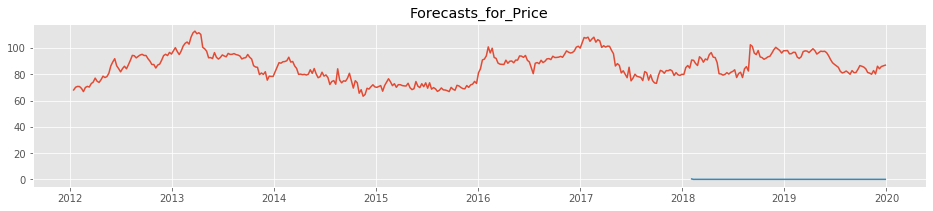

In [20]:
fig, ax = plt.subplots(1, figsize=(16, 3))
ax.plot(price_series.index, price_series)

# predictions = price_model.predict(
#    price_series.index.max(), pd.to_datetime('2020-09-12'), 
#    dynamic=True)

price_model = ARIMA(price_series, order=(1, 1, 1)).fit()

predictions = price_model.predict('2018-02-03', '2019-12-28', dynamic=True)
print(predictions)
ax.plot(predictions.index, predictions)
ax.set_title("Forecasts_for_Price")

If our model is good, the residuals should have no patterns whatsoever, i.e. be *white noise*

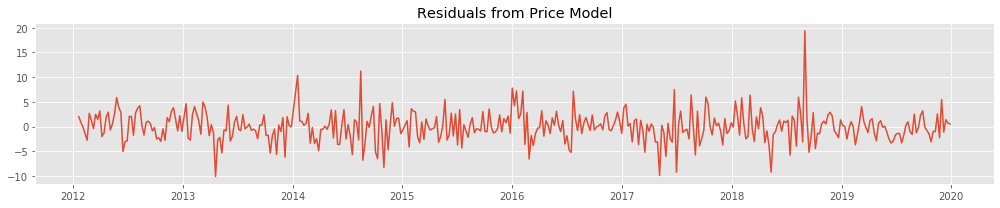

In [21]:
fig, ax = plt.subplots(1, figsize=(14, 3))
ax.plot(price_model.resid.index, price_model.resid)
ax.set_title("Residuals from Price Model")
plt.tight_layout()

One way to diagnose this is to check if any autocorrelation remains in the residuals.

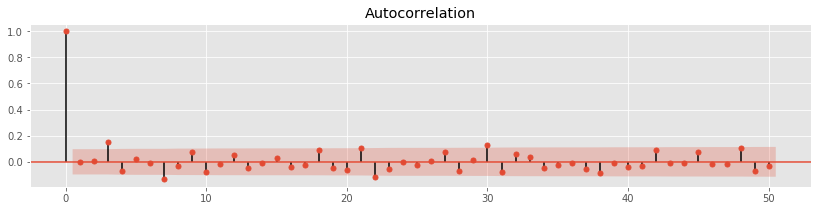

In [22]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_acf(price_model.resid, lags=50, ax=ax)

### Model Selection: AIC

In [23]:
parameters = [
    {'AR': 2, 'MA': 0},
    {'AR': 2, 'MA': 1},
    {'AR': 1, 'MA': 0},
    {'AR': 1, 'MA': 1},
    {'AR': 3, 'MA': 0},
    {'AR': 3, 'MA': 1}
]

models = {}
for params in parameters:
    models[(params['AR'], params['MA'])] = ARIMA(price_series, order=(params['AR'], 1, params['MA'])).fit()
    
for model_params in models:
    print("ARIMA({}, 1, {}) AIC: {}".format(model_params[0], model_params[1], models[model_params].aic))

ARIMA(2, 1, 0) AIC: 2090.478012840021
ARIMA(2, 1, 1) AIC: 2086.769481885772
ARIMA(1, 1, 0) AIC: 2088.6958921646024
ARIMA(1, 1, 1) AIC: 2090.625790904691
ARIMA(3, 1, 0) AIC: 2081.4707156798445
ARIMA(3, 1, 1) AIC: 2082.3967226022946


In [24]:
# Calculating MAPE (Mean Absolute Precentage Error)
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

## Poor results! Try Auto ARIMA

In [25]:
! pip install pmdarima

In [26]:
from pmdarima.arima import auto_arima

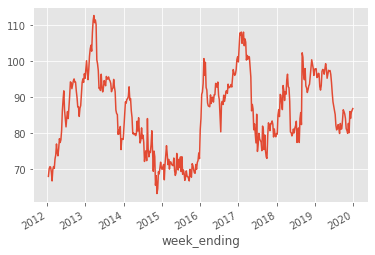

In [27]:
price_series.plot();

In [28]:
from pmdarima.arima import ADFTest

In [29]:
adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(price_series)

(0.23022144267525432, True)

#### Data is non-stationary

In [30]:
# Train test split. Use some data to train, then test against remaing data to evaluate the model.

price_series_train = price_series[:350]
price_series_test = price_series[350:] 

In [31]:
print(f'train on {len(price_series_train)} data points')
print(f'test on {len(price_series_test)} data points')

train on 350 data points
test on 62 data points


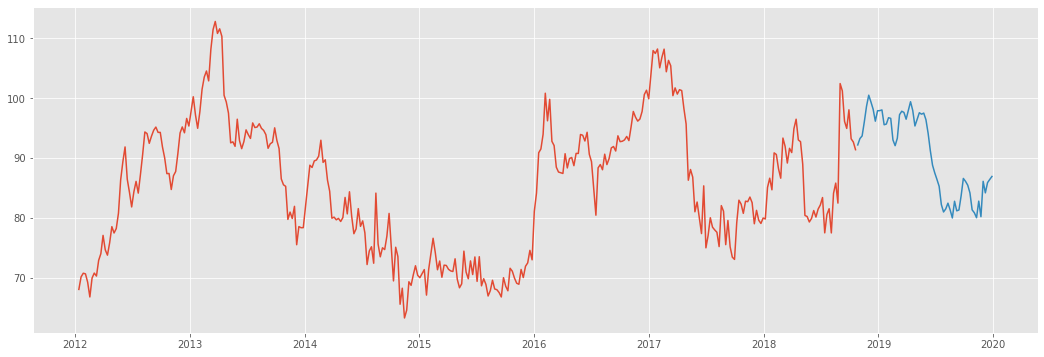

In [32]:
plt.figure(figsize=(18,6))
plt.plot(price_series_train)
plt.plot(price_series_test)


In [34]:
# retrain the best model on all data upto end 2019 NOTE: paramters narrowed after previous tests
SARIMAX_52_price_model = auto_arima(price_series, start_p=0, d=1, start_q=1, 
                                 max_p=0, max_d=1, max_q=1, start_P=2, D=1, start_Q=0,
                                 max_Q=0, m=52, seasonal=True,
                                 error_action='warn', trace=True,
                                 suppress_warnings=True, stepwise=True,
                                 random_state=13, n_fits=50)
SARIMAX_52_price_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,1)(2,1,0)[52]             : AIC=1940.700, Time=7.56 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=2111.761, Time=0.49 sec
 ARIMA(0,1,0)(1,1,0)[52]             : AIC=1983.043, Time=1.48 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=2094.521, Time=0.37 sec
 ARIMA(0,1,1)(1,1,0)[52]             : AIC=1971.459, Time=2.56 sec
 ARIMA(0,1,0)(2,1,0)[52]             : AIC=inf, Time=4.87 sec
 ARIMA(0,1,1)(2,1,0)[52] intercept   : AIC=1942.494, Time=14.91 sec

Best model:  ARIMA(0,1,1)(2,1,0)[52]          
Total fit time: 32.272 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  412
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 52)   Log Likelihood                -966.350
Date:                             Tue, 22 Sep 2020   AIC                           1940.700
Time:                                     16:22:02   BIC                           1956.233
Sample:                                          0   HQIC                          1946.877
                                             - 412                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1522      0.057     -2.686      0.007      -0.263      -0.041
ar.S.L52      -0.7561      0.055    -13.788      0.000      -0.864      -0.649
ar.S.L104     -0.3619      0.061     -5.948      0.000      -0.481      -0.243
sigma2        11.6067      0.640     18.144      0.000      10.353      12.860
===================================================================================
Ljung-Box (Q):                       75.96   Jarque-Bera (JB):               176.31
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                             0.60
Prob(H) (two-sided):                  0.48   Kurtosis:                         6.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### SARIMAX (0,1,1)(2,1,0)[52] with a seasonality of 52 weeks AIC = 1940.700

In [136]:
predictions = pd.DataFrame(SARIMAX_52_price_model.predict(n_periods=62),index=price_series_test.index)
predictions.columns = ['predicted_price']
predictions.index.shape


(62,)

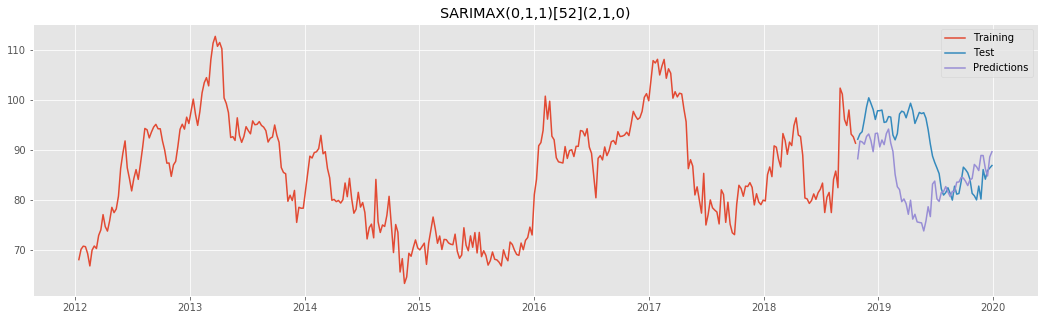

In [137]:
plt.figure(figsize=(18,5))
plt.plot(price_series_train, label='Training')
plt.plot(price_series_test, label='Test')
plt.plot(predictions.index, predictions, label='Predictions')
plt.legend(loc='Left corner')
plt.title('SARIMAX(0,1,1)[52](2,1,0)')
plt.savefig('../Images/SARIMAX(0,1,1)[52](2,1,0)')
plt.show()

In [91]:
# Calculating MAPE (Mean Absolute Precentage Error), as advised by Dr. Agrawal
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [92]:
print(f'SARIMAX_52 MAPE = {mape(price_series_test, predictions)}')

SARIMAX_52 MAPE = 9.447502540027388


#### SARIMAX_52 MAPE = 9.447502540027388

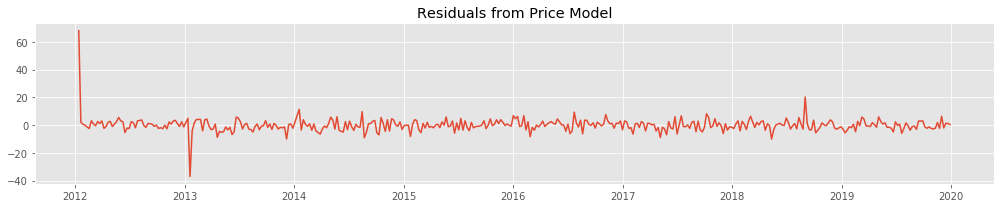

In [62]:
# Let's check the residuals to see if their variability looks like white noise

fig, ax = plt.subplots(1, figsize=(14, 3))
ax.plot(price_series.index, SARIMAX_52_price_model.resid())
ax.set_title("Residuals from Price Model")
plt.tight_layout()

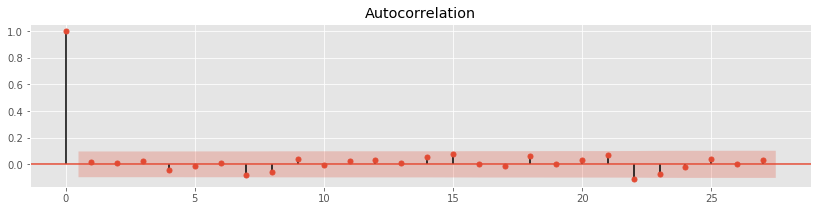

In [63]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_acf(SARIMAX_52_price_model.resid(), ax=ax)

#### Looks good! There are no significant autocorrelations.

#### We have results for seasonality 52 
##### Best model:  ARIMA(0,1,1)(2,1,0)[52] 

#### Now let's try with longer seasonalty of 104 & 156 weeks because seasonality from year to year is not apparent)

### SARIMAX (2,1,2)(2,1,0)[104] with a seasonality of 104 weeks AIC = 1662.785

In [45]:
# Let's try with different seasonality m=104 NOTE: these parameters were adjusted after wider earlier tests
SARIMAX_104_price_model = auto_arima(price_series, start_p=2, d=1, start_q=2, 
                              max_p=2, max_d=1, max_q=2, start_P=2, D=1, start_Q=0,
                              max_P=2, max_Q=0, m=104, seasonal=True,
                              error_action='warn', trace=True,
                              suppress_warnings=True, stepwise=True,
                              random_state=13, n_fits=50)
SARIMAX_104_price_model.summary()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(2,1,0)[104]             : AIC=1662.785, Time=199.69 sec
 ARIMA(0,1,0)(0,1,0)[104]             : AIC=1757.918, Time=1.55 sec
 ARIMA(1,1,0)(1,1,0)[104]             : AIC=inf, Time=9.84 sec
 ARIMA(0,1,1)(0,1,0)[104]             : AIC=1747.459, Time=1.63 sec
 ARIMA(2,1,2)(1,1,0)[104]             : AIC=1669.848, Time=54.74 sec
 ARIMA(1,1,2)(2,1,0)[104]             : AIC=1674.688, Time=77.57 sec
 ARIMA(2,1,1)(2,1,0)[104]             : AIC=1671.877, Time=97.92 sec
 ARIMA(1,1,1)(2,1,0)[104]             : AIC=1677.041, Time=49.22 sec
 ARIMA(2,1,2)(2,1,0)[104] intercept   : AIC=1664.596, Time=273.89 sec

Best model:  ARIMA(2,1,2)(2,1,0)[104]          
Total fit time: 766.259 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  412
Model:             SARIMAX(2, 1, 2)x(2, 1, [], 104)   Log Likelihood                -824.393
Date:                              Tue, 22 Sep 2020   AIC                           1662.785
Time:                                      16:40:48   BIC                           1688.873
Sample:                                           0   HQIC                          1673.218
                                              - 412                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9684      0.033    -29.211      0.000      -1.033      -0.903
ar.L2         -0.9570      0.028    -34.708      0.000      -1.011      -0.903
ma.L1          0.8800      0.043     20.688      0.000       0.797       0.963
ma.L2          0.9250      0.035     26.470      0.000       0.856       0.993
ar.S.L104     -0.6591      0.089     -7.398      0.000      -0.834      -0.484
ar.S.L208     -0.2964      0.112     -2.656      0.008      -0.515      -0.078
sigma2        10.6453      0.867     12.277      0.000       8.946      12.345
===================================================================================
Ljung-Box (Q):                       19.25   Jarque-Bera (JB):               100.58
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.30   Skew:                             0.56
Prob(H) (two-sided):                  0.19   Kurtosis:                         5.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Seasonality of 104 weeks gave model SARIMAX (2,1,2)(2,1,0)[104](AIC = 1662.785) 

#### And again check the residuals to see if their variability looks like white noise

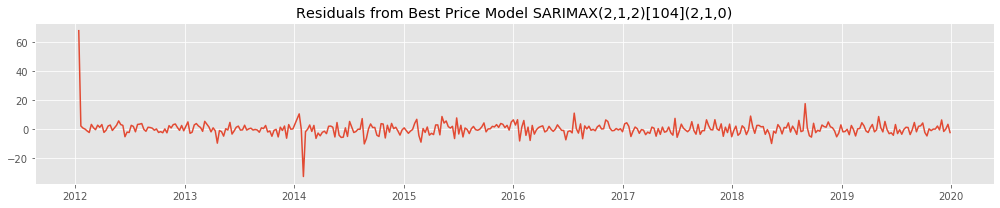

In [78]:
fig, ax = plt.subplots(1, figsize=(14, 3))
ax.plot(price_series.index, SARIMAX_104_price_model.resid())
ax.set_title('Residuals from Best Price Model SARIMAX(2,1,2)[104](2,1,0)')
plt.savefig('../Images/Residuals_from_SARIMAX(2,1,2)[104](2,1,0)')
plt.tight_layout()

#### and check for correlations

<Figure size 432x288 with 0 Axes>

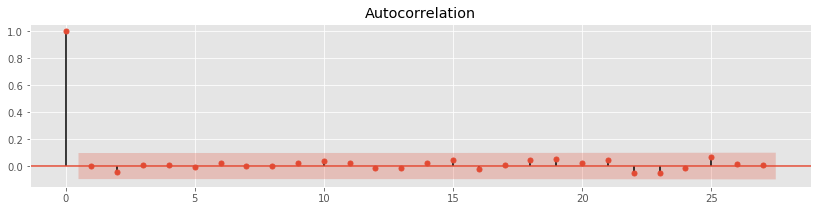

In [79]:
plt.savefig('../Images/Autocorrelation_from_SARIMA(2,1,2)[104](2,1,0)');
fig, ax = plt.subplots(1, figsize=(14, 3));
_ = sm.graphics.tsa.plot_acf(SARIMAX_104_price_model.resid(), ax=ax);

In [138]:
predictions = pd.DataFrame(SARIMAX_104_price_model.predict(n_periods=62),index=price_series_test.index)
predictions.columns = ['predicted_price']
predictions.index.shape

(62,)

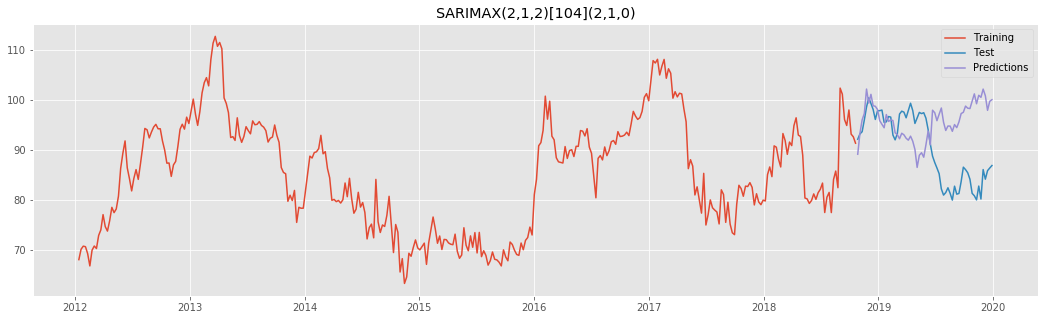

In [139]:
plt.figure(figsize=(18,5))
plt.plot(price_series_train, label='Training')
plt.plot(price_series_test, label='Test')
plt.plot(predictions.index, predictions, label='Predictions')
plt.legend(loc='Left corner')
plt.title('SARIMAX(2,1,2)[104](2,1,0)')
plt.savefig('../Images/SARIMAX(2,1,2)[104](2,1,0)')
plt.show()

In [140]:
print(f'SARIMAX_104 MAPE = {mape(price_series_test, predictions)}')

SARIMAX_104 MAPE = 8.577068336163782


#### SARIMAX_104 MAPE = 8.577068336163782

### Now let's try with a seasonalty of 156 weeks - tea plant maturity)

In [53]:
# SARIMAX_156_price_model = auto_arima(price_series, start_p=0, d=1, start_q=0, 
#                          max_p=5, max_d=5, max_q=5, start_P=0, D=1, start_Q=0,
#                          max_Q=5, m=156, seasonal=True,
#                          error_action='warn', trace=True,
#                          suppress_warnings=True, stepwise=True,
#                          random_state=13, n_fits=50)

# Performing stepwise search to minimize aic
#  ARIMA(0,1,0)(0,1,0)[156]             : AIC=1116.062, Time=2.50 sec
#  ARIMA(1,1,0)(1,1,0)[156]             : AIC=inf, Time=22.13 sec
#  ARIMA(0,1,1)(0,1,1)[156]             : AIC=inf, Time=23.79 sec
#  ARIMA(0,1,0)(1,1,0)[156]             : AIC=inf, Time=13.78 sec
#  ARIMA(0,1,0)(0,1,1)[156]             : AIC=inf, Time=17.38 sec
#  ARIMA(0,1,0)(1,1,1)[156]             : AIC=1117.473, Time=21.05 sec
#  ARIMA(1,1,0)(0,1,0)[156]             : AIC=1114.928, Time=2.89 sec
#  ARIMA(1,1,0)(0,1,1)[156]             : AIC=inf, Time=18.42 sec
#  ARIMA(1,1,0)(1,1,1)[156]             : AIC=1116.001, Time=28.03 sec
#  ARIMA(2,1,0)(0,1,0)[156]             : AIC=1116.778, Time=3.79 sec
#  ARIMA(1,1,1)(0,1,0)[156]             : AIC=1116.869, Time=5.93 sec
#  ARIMA(0,1,1)(0,1,0)[156]             : AIC=1114.882, Time=3.58 sec
#  ARIMA(0,1,1)(1,1,0)[156]             : AIC=1113.899, Time=21.53 sec
#  ARIMA(0,1,1)(2,1,0)[156]             : AIC=1115.899, Time=65.22 sec
#  ARIMA(0,1,1)(1,1,1)[156]             : AIC=1115.899, Time=27.35 sec
#  ARIMA(0,1,1)(2,1,1)[156]             : AIC=1117.899, Time=79.13 sec
#  ARIMA(1,1,1)(1,1,0)[156]             : AIC=1115.891, Time=36.71 sec
#  ARIMA(0,1,2)(1,1,0)[156]             : AIC=1115.876, Time=28.70 sec
#  ARIMA(1,1,2)(1,1,0)[156]             : AIC=1115.589, Time=60.87 sec
#  ARIMA(0,1,1)(1,1,0)[156] intercept   : AIC=1115.896, Time=29.67 sec

# Best model:  ARIMA(0,1,1)(1,1,0)[156]          
# Total fit time: 513.172 seconds

In [54]:
# Retrain SARIMAX_52 with narrower parameters based on previous results
SARIMAX_156_price_model = auto_arima(price_series, start_p=0, d=1, start_q=1, 
                         max_p=0, max_d=1, max_q=1, start_P=1, D=1, start_Q=0,
                         max_P=1, max_Q=0, m=156, seasonal=True,
                         error_action='warn', trace=True,
                         suppress_warnings=True, stepwise=True,
                         random_state=13, n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,1)(1,1,0)[156]             : AIC=1426.932, Time=23.97 sec
 ARIMA(0,1,0)(0,1,0)[156]             : AIC=1447.512, Time=3.08 sec
 ARIMA(0,1,0)(1,1,0)[156]             : AIC=inf, Time=12.48 sec
 ARIMA(0,1,1)(0,1,0)[156]             : AIC=1446.417, Time=4.94 sec
 ARIMA(0,1,1)(1,1,0)[156] intercept   : AIC=1428.756, Time=36.63 sec

Best model:  ARIMA(0,1,1)(1,1,0)[156]          
Total fit time: 81.182 seconds


### And again check the residuals to see if their variability looks like white noise

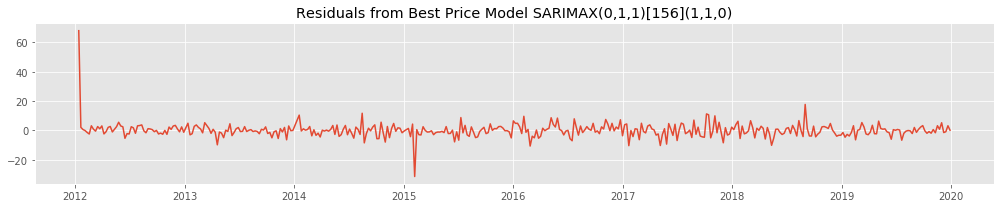

In [98]:
fig, ax = plt.subplots(1, figsize=(14, 3))
ax.plot(price_series.index, SARIMAX_156_price_model.resid())
ax.set_title('Residuals from Best Price Model SARIMAX(0,1,1)[156](1,1,0)')
plt.savefig('../Images/Residuals_from_SARIMAX(0,1,1)[156](1,1,0)')
plt.tight_layout()

### and check for correlations

<Figure size 432x288 with 0 Axes>

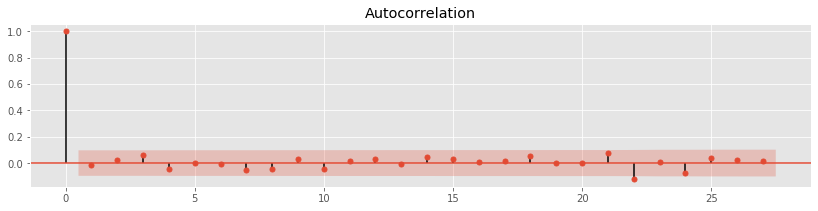

In [99]:
plt.savefig('../Images/Autocorrelation_from_SARIMAX(0,1,1)[156](1,1,0)')
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_acf(SARIMAX_156_price_model.resid(), ax=ax)

In [143]:
predictions = pd.DataFrame(SARIMAX_156_price_model.predict(n_periods=62),index=price_series_test.index)
predictions.columns = ['predicted_price']
predictions.index.shape

(62,)

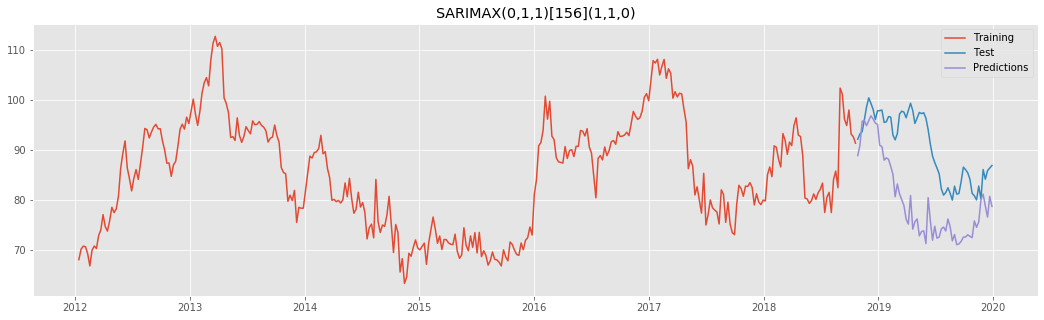

In [144]:
plt.figure(figsize=(18,5))
plt.plot(price_series_train, label='Training')
plt.plot(price_series_test, label='Test')
plt.plot(predictions.index, predictions, label='Predictions')
plt.legend(loc='Left corner')
plt.title('SARIMAX(0,1,1)[156](1,1,0)')
plt.savefig('../Images/SARIMAX(0,1,1)[156](1,1,0)')
plt.show()

In [145]:
print(f'SARIMAX_156 MAPE = {mape(price_series_test, predictions)}')

SARIMAX_156 MAPE = 13.787430238345333


#### SARIMAX_156 MAPE = 13.787430238345333

### Results based on data upto 2019
#### SARIMAX(0,1,1)(2,1,0)[52]  (AIC = 1940.700) (MAPE = 9.4475)
#### SARIMAX(2,1,2)(2,1,0)[104] with test data (AIC = 1662.785) (MAPE = 8.5770)  ......... BEST MODEL OVER TEST DATA
#### SARIMAX(0,1,1)(1,1,0)[156] with test data (AIC=1113.899) (MAPE = 13.7874)

In [297]:
# retrain the best model on all data upto end 2019
SARIMAX_104_price_model = auto_arima(price_series_train, start_p=2, d=1, start_q=2, 
                                 max_p=2, max_d=1, max_q=2, start_P=2, D=1, start_Q=0,
                                 max_P=2, max_Q=0, m=156, seasonal=True,
                                 error_action='warn', trace=True,
                                 suppress_warnings=True, stepwise=True,
                                 random_state=13, n_fits=50)


Performing stepwise search to minimize aic
 ARIMA(0,1,1)(1,1,0)[156]             : AIC=1113.899, Time=21.76 sec
 ARIMA(0,1,0)(0,1,0)[156]             : AIC=1116.062, Time=2.50 sec
 ARIMA(0,1,0)(1,1,0)[156]             : AIC=inf, Time=13.14 sec
 ARIMA(0,1,1)(0,1,0)[156]             : AIC=1114.882, Time=3.57 sec
 ARIMA(0,1,1)(2,1,0)[156]             : AIC=1115.899, Time=64.10 sec
 ARIMA(0,1,1)(1,1,0)[156] intercept   : AIC=1115.896, Time=28.41 sec

Best model:  ARIMA(0,1,1)(1,1,0)[156]          
Total fit time: 133.670 seconds


In [103]:
SARIMAX_104_price_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  412
Model:             SARIMAX(2, 1, 2)x(2, 1, [], 104)   Log Likelihood                -824.393
Date:                              Tue, 22 Sep 2020   AIC                           1662.785
Time:                                      17:28:08   BIC                           1688.873
Sample:                                           0   HQIC                          1673.218
                                              - 412                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9684      0.033    -29.211      0.000      -1.033      -0.903
ar.L2         -0.9570      0.028    -34.708      0.000      -1.011      -0.903
ma.L1          0.8800      0.043     20.688      0.000       0.797       0.963
ma.L2          0.9250      0.035     26.470      0.000       0.856       0.993
ar.S.L104     -0.6591      0.089     -7.398      0.000      -0.834      -0.484
ar.S.L208     -0.2964      0.112     -2.656      0.008      -0.515      -0.078
sigma2        10.6453      0.867     12.277      0.000       8.946      12.345
===================================================================================
Ljung-Box (Q):                       19.25   Jarque-Bera (JB):               100.58
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.30   Skew:                             0.56
Prob(H) (two-sided):                  0.19   Kurtosis:                         5.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [67]:
def show_mapes(model, model_name, weeks):
    
    mapes = []
    for week in weeks:
        fig, ax = plt.subplots(1, figsize=(16, 4))
        ax.plot(price_series.index[-52:], price_series[-52:], label='Train')

        results = model.arima_res_
        predictions = results.predict(412-week+1, 412, plot_insample=True)

        ax.plot(price_series.index[-week:], predictions, label='Predictions');
        # ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='k', alpha=0.1)
        ax.legend(loc='best')
        ax.set_ylabel('Rs. per Kg')
        ax.set_title(f"Forecasts for Price ({week} weeks) with {model_name}")
        plt.savefig(f'../Images/Forecasts_for_Price_{week}_weeks)_with_{model_name}')

        mapes.append(f'{model_name} MAPE for {week} weeks prediction = {mape(price_series[-week:], predictions)}')
    return mapes
    

['SARIMAX_52 MAPE for 52 weeks prediction = 1.6862462080014777']

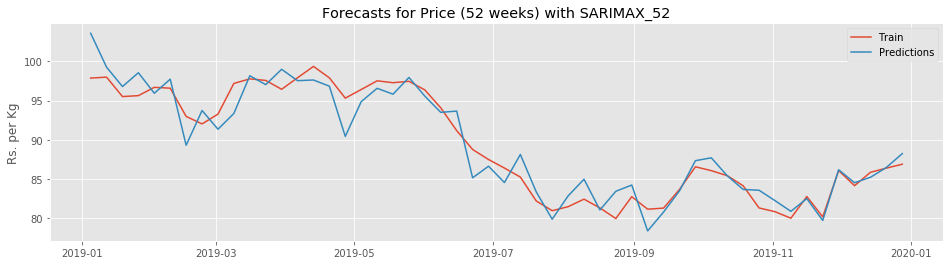

In [105]:
show_mapes(SARIMAX_52_price_model, 'SARIMAX_52', [52])

['SARIMAX_104 MAPE for 52 weeks prediction = 1.7559606025490289']

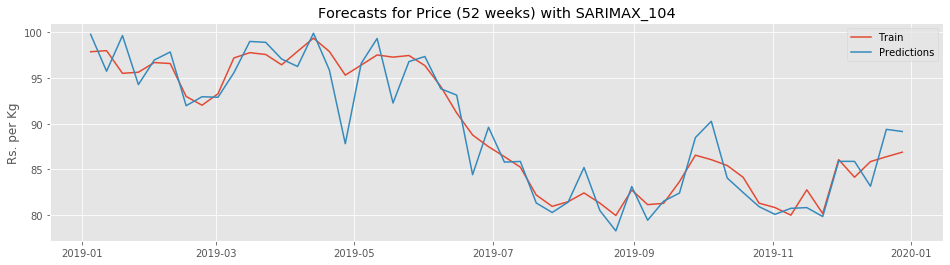

In [106]:
show_mapes(SARIMAX_104_price_model, 'SARIMAX_104', [52])

['SARIMAX_156 MAPE for 52 weeks prediction = 1.6684327791105298']

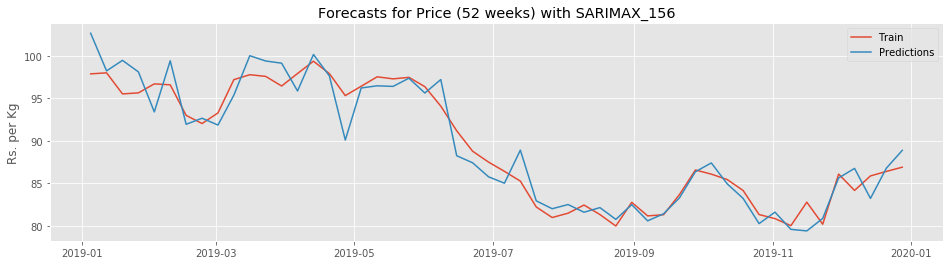

In [107]:
show_mapes(SARIMAX_156_price_model, 'SARIMAX_156', [52])

In [290]:
print(f'MAPE for 4 weeks prediction = {mape(price_series[-4:], predictions)}')


MAPE for 4 weeks prediction = 25.275598077345563


### Predict 3 weeks into 2020

In [108]:
# Actuals for 2020 (pre-COVID end february)
price_series_2020_pc = df_CHN_CTC_leaf_2020['ctc_leaf_avg_price'].iloc[:3]
price_series_2020_pc.index = pd.date_range(start='2020-01-04', end='2020-01-18', freq='W-SAT')
price_series_2020_pc

2020-01-04    87.80
2020-01-11    87.36
2020-01-18    87.68
Freq: W-SAT, Name: ctc_leaf_avg_price, dtype: float64

#### For SARIMAX_price_model (52 weeks seasonality)

In [117]:
#fig, ax = plt.subplots(1, figsize=(16, 4))

predictions_index = pd.date_range(start='2020-01-04', end='2020-01-18', freq='W-SAT')
predictions = SARIMAX_52_price_model.predict(3)
#predictions.index = predictions_index
predictions

array([88.24192662, 91.7890666 , 91.61761616])

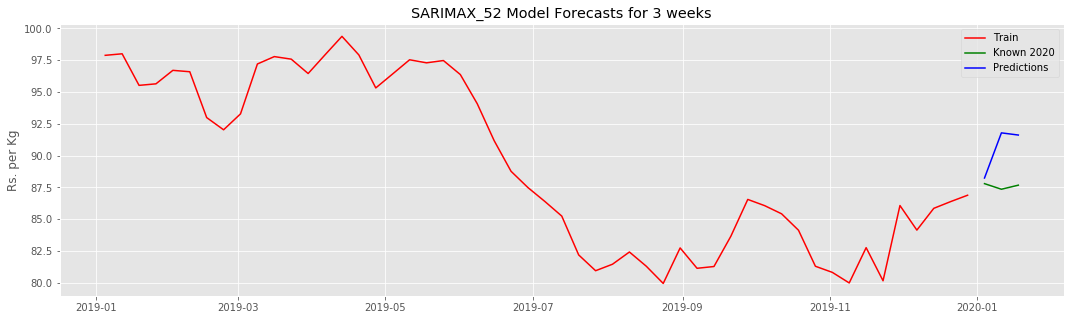

In [124]:
plt.figure(figsize=(18, 5))
plt.plot(price_series.index[-52:], price_series[-52:], label='Train', c='r')
plt.plot(price_series_2020_pc.index[:3], price_series_2020_pc[:3], label='Known 2020', c='g')
plt.plot(predictions_index, predictions, label='Predictions', c='b')

plt.title("SARIMAX_52 Model Forecasts for 3 weeks")
plt.legend(loc='best')
plt.ylabel('Rs. per Kg')
plt.savefig('../Images/SARIMAX_52_Model_Forecasts_for_3_weeks')

plt.show();

In [125]:
print(f'SARIMAX(52 weeks seasonality) MAPE for 3 weeks prediction = {mape(price_series_2020_pc[:3], predictions[:3])}')

SARIMAX(52 weeks seasonality) MAPE for 3 weeks prediction = 3.3547099549710047


#### For SARIMAX_104_price_model (104 weeks seasonality)

In [126]:
predictions_index = pd.date_range(start='2020-01-04', end='2020-01-18', freq='W-SAT')
predictions = SARIMAX_104_price_model.predict(3)
predictions

array([89.15239214, 93.34569545, 96.03063747])

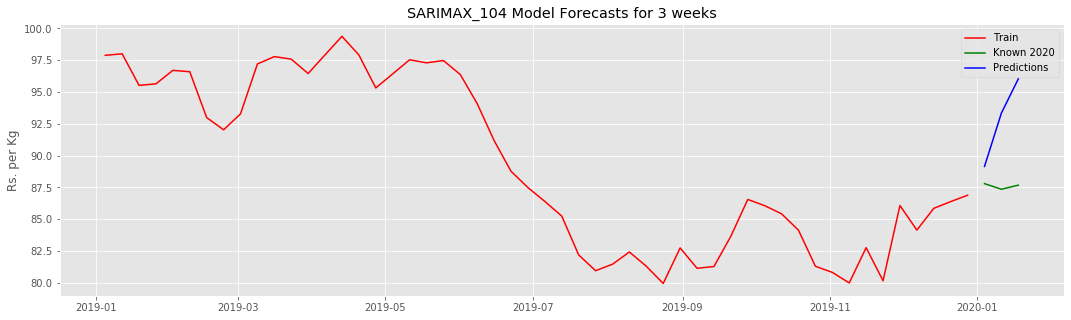

In [127]:
plt.figure(figsize=(18, 5))
plt.plot(price_series.index[-52:], price_series[-52:], label='Train', c='r')
plt.plot(price_series_2020_pc.index[:3], price_series_2020_pc[:3], label='Known 2020', c='g')
plt.plot(predictions_index, predictions, label='Predictions', c='b')

plt.title("SARIMAX_104 Model Forecasts for 3 weeks")
plt.legend(loc='best')
plt.ylabel('Rs. per Kg')
plt.savefig('../Images/SARIMAX_104_Model_Forecasts_for_3_weeks')

plt.show();

In [128]:
print(f'SARIMAX(104 weeks seasonality) MAPE for 3 weeks prediction = {mape(price_series_2020_pc[:3], predictions[:3])}')

SARIMAX(104 weeks seasonality) MAPE for 3 weeks prediction = 5.972020338701398


#### For SARIMAX_156_price_model (104 weeks seasonality)

In [131]:
predictions_index = pd.date_range(start='2020-01-04', end='2020-01-18', freq='W-SAT')
predictions = SARIMAX_156_price_model.predict(3)
#predictions.index = predictions_index
predictions

array([88.8719794 , 90.91809261, 95.75262785])

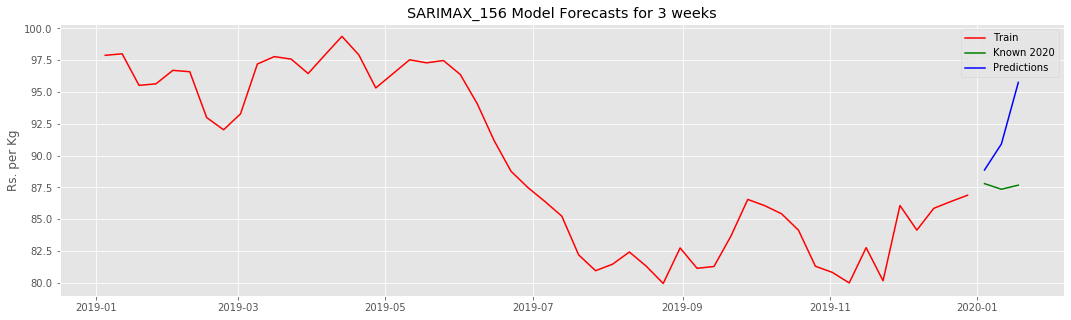

In [133]:
plt.figure(figsize=(18, 5))
plt.plot(price_series.index[-52:], price_series[-52:], label='Train', c='r')
plt.plot(price_series_2020_pc.index[:3], price_series_2020_pc[:3], label='Known 2020', c='g')
plt.plot(predictions_index, predictions, label='Predictions', c='b')

plt.title("SARIMAX_156 Model Forecasts for 3 weeks")
plt.legend(loc='best')
plt.ylabel('Rs. per Kg')
plt.savefig('../Images/SARIMAX_156_Model_Forecasts_for_3_weeks')

plt.show();

In [134]:
print(f'SARIMAX(156 weeks seasonality) MAPE for 3 weeks prediction = {mape(price_series_2020_pc[:3], predictions[:3])}')

SARIMAX(156 weeks seasonality) MAPE for 3 weeks prediction = 4.83358730716274


## TBDs

- Multivariate SARIMAX
- Holt Winters